## generate previous frames with pCO2 and fit it against ConvLSTM for multiple members

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras
import os

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray, custom_rmse

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced,preprocess_images_nfp, inverse_scale_frame
from data_preprocess import preprocess_images, inverse_scale_image, preprocess_image_reduced

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-09-26 11:07:59.799240: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


### Previous Frame generation

In [2]:
dist_map = pd.read_csv("../../src/dist_map.csv",header=None).to_numpy()
dist_map = np.roll(np.fliplr(dist_map),180)
dist_map = np.repeat(dist_map[np.newaxis, :, : ], 421, axis=0)

def custom_rmse2(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    + difference between sss
    """
    idx  = tf.not_equal(y_true, 0.0)
    idx2  = tf.equal(y_true, 0.0)
    
    y_pred1 = tf.boolean_mask(y_pred,idx)
    y_true1 = tf.boolean_mask(y_true,idx)
    y_true1 = tf.cast(y_true1, y_pred.dtype)
    
    rmse1 = K.sqrt(K.mean(tf.math.squared_difference(y_pred1, y_true1),axis= -1))
    
    #y_pred2 = tf.boolean_mask(y_pred,idx2)
    #loss2 = 10*(K.var(y_true1)/K.var(y_pred2))
    #loss2 = tf.cast(loss2, y_pred.dtype)
    
    return rmse1


In [3]:
# Reading Data
dir = "../../data/"
dir_name = "../../data/member_001"
data_nums = ["001", "002", "009", "010", "011", "012", "013", "014", "015", "016", "017", "018", "020",
             "021", "023", "024", "025", "030", "031", "034", "035", "101", "102", "103", "104"]

X_all = np.empty((0, 180, 360, 5))
y_all = np.empty((0, 180, 360))

for i in range(3):
    dir_name = dir + "member_" + str(data_nums[i])
    chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2 = read_xarray(dir_name,num =data_nums[i])
    
    chl_images = preprocess_image_reduced(chl.Chl.data)
    sss_images = preprocess_image_reduced(sss.SSS.data)
    sst_images = preprocess_image_reduced(sst.SST.data)
    mld_images = preprocess_image_reduced(mld.MLD.data)
    xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
    y1 = preprocess_image_reduced(pco2.pCO2.data)
    dist_map = preprocess_image_reduced(dist_map)
    X1 = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images))
    #X1 = np.dstack((chl_images, mld_images, sss_images, sst_images, xco2_images))
    X1 = X1.reshape((421,180,360,5),order='F')
    
    X_all = np.concatenate((X_all, X1))
    y_all = np.concatenate((y_all, y1))


/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
INPUT_SHAPE=X_all[0].shape
OUTPUT_SHAPE=y_all[0].shape

INPUT_SHAPE, X_all.shape, y_all.shape

((180, 360, 5), (1263, 180, 360, 5), (1263, 180, 360))

In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=5,activation='elu',
                        padding="SAME")

base_model = keras.models.Sequential([
    DefaultConv2D(filters=32, input_shape=INPUT_SHAPE),
    DefaultConv2D(filters=32),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Dropout(0.2),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Dropout(0.2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    keras.layers.Dropout(0.2),
    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=32),
    DefaultConv2D(filters=2),
    DefaultConv2D(filters=1,kernel_size=1),
    keras.layers.Reshape(OUTPUT_SHAPE)
])

myLearnRate=0.0005
custom_opt = tf.keras.optimizers.Adam(learning_rate=myLearnRate)

#rmse 13



base_model.compile(loss=custom_rmse, optimizer=custom_opt)

In [ ]:


model_path="../../models/base_model/u_net_dist.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

history = base_model.fit(X_all,y_all, epochs=200, 
                         validation_data=(X_all,y_all),
                         workers=-1,batch_size=16,
                         callbacks=callbacks)




In [5]:
cnn_model = tf.keras.models.load_model('../../models/base_model/u_net_dist.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_image= cnn_model.predict(X_all,verbose=1)
#predicted_image[y_all==0]=0.0

2022-09-26 11:08:32.118688: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-26 11:08:32.179852: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-26 11:08:32.509836: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 72 deviceMemorySize: 44.49GiB deviceMemoryBandwidth: 581.23GiB/s
2022-09-26 11:08:32.509924: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-09-26 11:08:34.123187: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-09-26 11:08:34.123305: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-0

40/40 [==============================] - 96s 86ms/step


In [34]:
print(custom_rmse(predicted_image,y_all))

tf.Tensor(3.3854419655263928, shape=(), dtype=float64)


In [35]:

y_true_all = np.empty((0,180,360))
y_pred_all = np.empty((0,180,360))


for i in range(3):
    tmp = i+1
    dir_name = dir + "member_" + str(data_nums[i])
    chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2t2 = read_xarray(dir_name,num =data_nums[i])
    y_true,y_pred = inverse_scale_image(predicted_image[421*(tmp-1):421*tmp],pco2t2.pCO2.data)
    y_true_all = np.concatenate((y_true_all, y_true))
    y_pred_all = np.concatenate((y_pred_all, y_pred))


print("y_shapes:", y_true_all.shape, y_pred_all.shape)
print("Full RMSE score:")
a=custom_rmse(y_pred_all,y_true_all)
print(a.numpy())


y_shapes: (1263, 180, 360) (1263, 180, 360)
Full RMSE score:
10.189230414266


### Using the prediction as input in ConvLSTM

In [6]:
X_all_conv = np.empty((0, 3, 180, 360, 6))
y_all_conv = np.empty((0, 3, 180, 360, 1))
X_index=np.lib.stride_tricks.sliding_window_view(range(421),3)

tmp = 1

for i in range(3):
    dir_name = dir + "member_" + str(data_nums[i])
    chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2 = read_xarray(dir_name,num=data_nums[i])

    chl_images = preprocess_image_reduced(chl.Chl.data)
    sss_images = preprocess_image_reduced(sss.SSS.data)
    sst_images = preprocess_image_reduced(sst.SST.data)
    xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
    pco2 = preprocess_image_reduced(pco2.pCO2.data)
    dist_map = preprocess_image_reduced(dist_map)
    
    y = np.expand_dims(pco2[X_index][1:], axis=4)
    
    X = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images,predicted_image[421*(tmp-1):421*tmp]))
    tmp+=1
    X = X.reshape((421,180,360,6),order='F')
    X = X[X_index][:-1]
    
    X_all_conv = np.concatenate((X_all_conv, X))
    y_all_conv = np.concatenate((y_all_conv, y))


shuffle_ind = (np.arange(X_all_conv.shape[0]))
np.random.shuffle(shuffle_ind)
X_all_conv = np.array(X_all_conv)[shuffle_ind.astype(int)]
y_all_conv = np.array(y_all_conv)[shuffle_ind.astype(int)]

X_all_conv.shape, y_all_conv.shape

((1254, 3, 180, 360, 6), (1254, 3, 180, 360, 1))

In [7]:
INPUT_SHAPE=X_all_conv[0].shape
OUTPUT_SHAPE=y_all_conv[0].shape

INPUT_SHAPE

(3, 180, 360, 6)

In [8]:
tf.keras.backend.clear_session()
from functools import partial


DefaultConvLSTM2D = partial(keras.layers.ConvLSTM2D,
                        filters=32, kernel_size=(5, 5),
                        padding="same",return_sequences=True,
                        activation="elu",)



model = keras.models.Sequential([
    DefaultConvLSTM2D(input_shape=INPUT_SHAPE),
    keras.layers.BatchNormalization(),
    DefaultConvLSTM2D(kernel_size=(5,5)),
    keras.layers.BatchNormalization(),
    DefaultConvLSTM2D(kernel_size=(3,3)),
    keras.layers.BatchNormalization(),
    DefaultConvLSTM2D(kernel_size=(1,1)),
    keras.layers.Conv3D(filters = 1, kernel_size=(3,3,3),activation="elu", padding="same")
    
])


model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.99),
)

In [9]:
model_path="../../models/ConvLSTM_with_pco2_2.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=6, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 100
batch_size = 8

# Fit the model to the training data.
hist = model.fit(
    X_all_conv,
    y_all_conv,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_all_conv,y_all_conv),
    callbacks=callbacks,
)

Epoch 1/100
157/157 [==============================] - 244s 1s/step - loss: 49.7364 - val_loss: 13.9513
Epoch 2/100
157/157 [==============================] - 208s 1s/step - loss: 6.3115 - val_loss: 6.2178
Epoch 3/100
157/157 [==============================] - 204s 1s/step - loss: 5.1817 - val_loss: 4.5525
Epoch 4/100
157/157 [==============================] - 204s 1s/step - loss: 5.3996 - val_loss: 7.8429
Epoch 5/100
157/157 [==============================] - 207s 1s/step - loss: 4.6691 - val_loss: 4.3037
Epoch 6/100
157/157 [==============================] - 208s 1s/step - loss: 4.5532 - val_loss: 4.2115
Epoch 7/100
157/157 [==============================] - 207s 1s/step - loss: 4.6531 - val_loss: 5.4529
Epoch 8/100
157/157 [==============================] - 207s 1s/step - loss: 4.2487 - val_loss: 4.2412
Epoch 9/100
157/157 [==============================] - 205s 1s/step - loss: 4.6093 - val_loss: 5.9128
Epoch 10/100
157/157 [==============================] - 205s 1s/step - loss: 4.1

In [11]:
# the masking continents for continent works better for pretrained model

## transfer learning on MPI


In [12]:
# CNN on MPI
cnn_model_path="../../models/base_model/u_net_dist.h5"
cnn_model = tf.keras.models.load_model(cnn_model_path, custom_objects={'custom_rmse':custom_rmse})

mpi_data_path = "../../data/mpi_001"


def read_xarray_mpi(dir_name="",num="006"):
    '''
     read_xarray(dir)name) opens data and returns data in xarray format for each feature mpi
    '''
    date="198201-201701"
  
    file_type ="MPI"
        
    chl = xr.open_dataset(f'{dir_name}/Chl_2D_mon_{file_type}{num}_1x1_{date}.nc')

    mld = xr.open_dataset(f'{dir_name}/MLD_2D_mon_{file_type}{num}_1x1_{date}.nc')

    sss = xr.open_dataset(f'{dir_name}/SSS_2D_mon_{file_type}{num}_1x1_{date}.nc')

    sst = xr.open_dataset(f'{dir_name}/SST_2D_mon_{file_type}{num}_1x1_{date}.nc')

    xco2 = xr.open_dataset(f'../../data/member_001/XCO2_1D_mon_CESM001_native_198201-201701.nc')

    pco2 = xr.open_dataset(f'{dir_name}/pCO2_2D_mon_{file_type}{num}_1x1_{date}.nc')

    return chl,mld,sss,sst,xco2,pco2


chl,mld,sss,sst,xco2,pco2 = read_xarray_mpi(mpi_data_path)
chl_images = preprocess_image_reduced(chl.Chl.data)
sss_images = preprocess_image_reduced(sss.SSS.data)
sst_images = preprocess_image_reduced(sst.SST.data)
mld_images = preprocess_image_reduced(mld.MLD.data)
xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)

def pco2_socat_preprocess(arr):
    nans=np.isnan(arr)
    min_val=arr[~nans].min()
    arr[nans]=min_val
    return arr
        
pco2_socat_images = pco2_socat_preprocess(pco2.pCO2_socat.data)

dist_map = preprocess_image_reduced(dist_map)
    
X_tf = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images))
y_tf = pco2_socat_images
X_tf = X_tf.reshape((421,180,360,5),order='F')
# penalize smaller variance


In [38]:
np.min(pco2_socat_images), np.max(pco2_socat_images)

(0.0, 710.2517700195312)

In [39]:
# without tf performance
y_tf=cnn_model.predict(X_tf)
y_true,y_pred=inverse_scale_image(y_tf,pco2.pCO2.data)
custom_rmse(y_true,y_pred)


<tf.Tensor: shape=(), dtype=float32, numpy=64.42476>

In [46]:
# transfer learning
for layer in cnn_model.layers[:-4]:
    layer.trainable = False

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 360, 32)      4032      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 360, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 120, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 120, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 120, 64)       51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 120, 64)       102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 40, 64)        0

In [48]:
from tensorflow.keras import backend as K

tf.keras.backend.clear_session()


def custom_rmse2(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    + difference between sss
    """
    idx  = tf.not_equal(y_true, 0.0)
    idx2  = tf.equal(y_true, 0.0)
    
    y_pred1 = tf.boolean_mask(y_pred,idx)
    y_true1 = tf.boolean_mask(y_true,idx)
    y_true1 = tf.cast(y_true1, y_pred.dtype)
    
    rmse1 = K.sqrt(K.mean(tf.math.squared_difference(y_pred1, y_true1),axis= -1))
    
    #y_pred2 = tf.boolean_mask(y_pred,idx2)
    #loss2 = 10*(K.var(y_true1)/K.var(y_pred2))
    #loss2 = tf.cast(loss2, y_pred.dtype)
    
    return rmse1


myLearnRate=0.001

cnn_model.compile(
    loss=custom_rmse2, optimizer=keras.optimizers.Adam(learning_rate=myLearnRate),
)

model_path="../../models/transfer_CNN.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

history = cnn_model.fit(X_tf,y_tf, epochs=200, 
                         validation_data=(X_tf,y_tf),
                         workers=-1,batch_size=64,
                         callbacks=callbacks)

Epoch 1/200
7/7 [==============================] - 4s 517ms/step - loss: 196.8509 - val_loss: 157.7825
Epoch 2/200
7/7 [==============================] - 3s 493ms/step - loss: 140.0644 - val_loss: 128.4747
Epoch 3/200
7/7 [==============================] - 3s 495ms/step - loss: 107.5605 - val_loss: 83.6558
Epoch 4/200
7/7 [==============================] - 3s 495ms/step - loss: 71.7426 - val_loss: 56.5183
Epoch 5/200
7/7 [==============================] - 3s 493ms/step - loss: 56.2329 - val_loss: 50.6332
Epoch 6/200
7/7 [==============================] - 3s 494ms/step - loss: 51.2099 - val_loss: 44.0104
Epoch 7/200
7/7 [==============================] - 3s 494ms/step - loss: 46.4189 - val_loss: 41.1047
Epoch 8/200
7/7 [==============================] - 3s 492ms/step - loss: 42.4774 - val_loss: 37.5489
Epoch 9/200
7/7 [==============================] - 3s 496ms/step - loss: 40.9518 - val_loss: 34.9352
Epoch 10/200
7/7 [==============================] - 3s 494ms/step - loss: 39.2081 - va

In [ ]:
# myLearnRate=0.0005
# tf.keras.backend.clear_session()

# cnn_model.compile(
#     loss=custom_rmse, optimizer=keras.optimizers.Adam(learning_rate=myLearnRate),
# )

# model_path="../../models/transfer_CNN_2.h5"

# early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
# checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
# callbacks=[early_stopings,checkpoint]

# history2 = cnn_model.fit(X_tf,y_tf, epochs=200, 
#                          validation_data=(X_tf,y_tf),
#                          workers=-1,batch_size=32,
#                          callbacks=callbacks)

In [13]:
#cnn_model = tf.keras.models.load_model('../../models/transfer_CNN_2.h5', custom_objects={'custom_rmse':custom_rmse})
cnn_model = tf.keras.models.load_model('../../models/transfer_CNN.h5', custom_objects={'custom_rmse2':custom_rmse2})


predicted_image = cnn_model.predict(X_tf,verbose=1)

chl,mld,sss,sst,xco2,pco2 = read_xarray_mpi(mpi_data_path)
coord = np.isnan(pco2.pCO2.data)
# previous frame with continent masked or not masked?
#predicted_image[coord] = 0

full_truth = pco2.pCO2.data
full_truth[coord] = 0

14/14 [==============================] - 4s 227ms/step


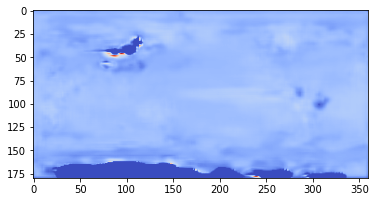

In [14]:
plt.imshow(np.flipud(predicted_image[0]),cmap="coolwarm")

In [ ]:
custom_rmse(predicted_image,full_truth)

In [15]:
X_index=np.lib.stride_tricks.sliding_window_view(range(421),3)
X = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images,predicted_image))
X = X.reshape((421,180,360,6),order='F')
X = X[X_index][:-1]

y_tf=np.expand_dims(y_tf[X_index][1:],axis=4)

In [10]:
X.shape, y_tf.shape # changed sliding

((418, 3, 180, 360, 6), (418, 3, 180, 360, 1))

In [16]:
tf.keras.backend.clear_session()

convlstm_model_path = "../../models/ConvLSTM_with_pco2_2.h5"
convlstm_model = tf.keras.models.load_model(convlstm_model_path, custom_objects={'custom_rmse':custom_rmse})


In [17]:
chl,mld,sss,sst,xco2,pco2t2 = read_xarray_mpi(mpi_data_path)


tmp = np.nan_to_num(pco2t2.pCO2.data[X_index][1:])
y_true_full = np.expand_dims(tmp,axis=4)
y_true_full.shape

coord = (y_true_full==0.0)

predicted_frames= convlstm_model.predict(X,verbose=1)
predicted_frames[coord] = 0

print("ConvLSTM Full RMSE score w/o finetuning:")
a=custom_rmse(predicted_frames[:,1:2],y_true_full[:,1:2])
print(a)

14/14 [==============================] - 16s 1s/step
ConvLSTM Full RMSE score w/o finetuning:
tf.Tensor(99.70362, shape=(), dtype=float32)


In [18]:
for layer in convlstm_model.layers[:-2]:
    layer.trainable = False

    # -3 96uatm
convlstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 3, 180, 360, 32)   121728    
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 3, 180, 360, 32)   204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 3, 180, 360, 32)   73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 3, 180, 360, 32)   8

In [19]:
convlstm_model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(learning_rate=1e-3),
)

model_path="../../models/transfer_CNN_LSTM.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 50
batch_size = 16

In [20]:
history = convlstm_model.fit(
    X,
    y_tf,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X, y_tf),
    callbacks=callbacks,
)

Epoch 1/50
27/27 [==============================] - 48s 2s/step - loss: 82.5737 - val_loss: 36.1782
Epoch 2/50
27/27 [==============================] - 38s 1s/step - loss: 36.9207 - val_loss: 32.9661
Epoch 3/50
27/27 [==============================] - 38s 1s/step - loss: 35.0269 - val_loss: 33.0684
Epoch 4/50
27/27 [==============================] - 38s 1s/step - loss: 33.6780 - val_loss: 31.3121
Epoch 5/50
27/27 [==============================] - 38s 1s/step - loss: 32.9005 - val_loss: 31.0541
Epoch 6/50
27/27 [==============================] - 38s 1s/step - loss: 31.9595 - val_loss: 30.8994
Epoch 7/50
27/27 [==============================] - 38s 1s/step - loss: 31.5832 - val_loss: 30.5744
Epoch 8/50
27/27 [==============================] - 38s 1s/step - loss: 31.7169 - val_loss: 30.7374
Epoch 9/50
27/27 [==============================] - 38s 1s/step - loss: 31.2500 - val_loss: 29.7624
Epoch 10/50
27/27 [==============================] - 38s 1s/step - loss: 31.4156 - val_loss: 29.6050

In [21]:
chl,mld,sss,sst,xco2,pco2t2 = read_xarray_mpi(mpi_data_path)

tmp = np.nan_to_num(pco2t2.pCO2.data[X_index][1:])
y_true_full = np.expand_dims(tmp,axis=4)
y_true_full.shape

coord = (y_true_full==0.0)


In [23]:
tf_model = tf.keras.models.load_model("../../models/transfer_CNN_LSTM.h5", custom_objects={'custom_rmse':custom_rmse})

predicted_frames= tf_model.predict(X,verbose=1)
predicted_frames[coord] = 0

print("Full RMSE score:")
a=custom_rmse(predicted_frames[:,1:2],y_true_full[:,1:2])
print(a)

# with continent masked from previous frame RMSE : 33.09
# without continent masked from previous frame RMSE: 32.29
## - noticed it converges faster
## not much difference

14/14 [==============================] - 15s 1s/step
Full RMSE score:
tf.Tensor(32.29296, shape=(), dtype=float32)


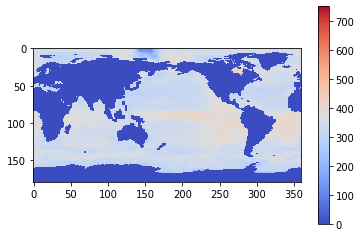

In [24]:
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=0, vmax = 750)


img=plt.imshow(np.flipud(predicted_frames[0,1:2][0]),cmap="coolwarm", interpolation="nearest", norm=norm)
plt.colorbar(img)

### GIF generation

In [51]:
# gif generation for cnn

import matplotlib.colors as mcolors
import imageio

chl,mld,sss,sst,xco2,pco2 = read_xarray_mpi(mpi_data_path)
full_truth = pco2.pCO2.data
full_truth[coord] = 0

norm = mcolors.Normalize(vmin=0, vmax = 750)
norm2 = mcolors.TwoSlopeNorm(vmin=-500, vmax = 500, vcenter=0)


filenames = []

for i in range(421):
    figure, axis = plt.subplots(1, 3,figsize=(18, 10))
    
    img=axis[0].imshow(np.flipud(predicted_image[i]),cmap="coolwarm", interpolation="nearest", norm=norm)
    axis[0].set_title("prediction")
    plt.colorbar(img,ax=axis)

    img1=axis[1].imshow(np.flipud(full_truth[i]),cmap="coolwarm", interpolation="nearest",norm=norm)
    axis[1].set_title("true")

    img2=axis[2].imshow(np.flipud(full_truth[i]-(predicted_image[i])),cmap="RdBu", norm=norm2)
    axis[2].set_title("residual")
    plt.colorbar(img2,ax=axis)
    
    text = "rmse: "+str(np.round(np.sqrt(np.mean((full_truth[i]-predicted_image[i])**2)),2))
    plt.text(-60, -60, text, fontsize = 20)
    
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()


with imageio.get_writer('../../assets/cnn_mpi_transfer.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)



In [28]:
# gif generation for conv-lstm
import imageio

norm = mcolors.Normalize(vmin=0, vmax = 750)
norm2 = mcolors.TwoSlopeNorm(vmin=-500, vmax = 500, vcenter=0)


filenames = []

for i in range(418):
    figure, axis = plt.subplots(1, 3,figsize=(18, 10))
    
    img=axis[0].imshow(np.flipud(predicted_frames[i,1:2][0]),cmap="coolwarm", interpolation="nearest", norm=norm)
    axis[0].set_title("prediction")
    plt.colorbar(img,ax=axis)

    img1=axis[1].imshow(np.flipud(y_true_full[i,1:2][0]),cmap="coolwarm", interpolation="nearest",norm=norm)
    axis[1].set_title("true")

    img2=axis[2].imshow(np.flipud(y_true_full[i,1:2][0]-(predicted_frames[i,1:2][0])),cmap="RdBu", norm=norm2)
    axis[2].set_title("residual")
    plt.colorbar(img2,ax=axis)
    
    text = "rmse: "+str(np.round(np.sqrt(np.mean((y_true_full[i,1:2][0]-predicted_frames[i,1:2][0])**2)),2))
    plt.text(-60, -60, text, fontsize = 20)
    
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()


with imageio.get_writer('../../assets/convlstm_mpi_transfer_2.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)



In [ ]:
def inverse_scale_frame_socat(arr,df, X_index=[]):
    """
    inverse_scale_frame(arr, df):
    - inverses the pco2 scaling
    """
    old_min = 0
    df_tmp = df[df!=0.0]
    old_max = np.nanmax(df_tmp)
    y_pred = arr*(old_max-old_min)/255+old_min
    tmp=np.nan_to_num(df[X_index][1:])
    y_true=np.expand_dims(tmp,axis=4)
    y_pred[y_true==0]=0
    return y_true,y_pred

